# Summary of Ammundsen Sea Data Annual and TSX

In [2]:
%load_ext autoreload
%autoreload 2
import nisardev as nisar
import os
from urllib import request
import grimpfunc as grimp
import matplotlib.pyplot as plt
import pyproj
import numpy as np
from datetime import datetime
import geopandas as gpd
import glob
import utilities as u
from matplotlib import cm

## Plot Routines

This routine will take a polylline segment and fill in between the points.

In [3]:
def processProfile(xls, yls, deltaX):
    ''' For a series lines segments forming a polyline (xl,yl),
    sample with nearly uniform spacing deltaX'''
    # Setup return values
    xdom, ydom, dist = np.array([]), np.array([]), np.array([])
    # Compute distances for each segment
    dxs, dys = np.diff(xls), np.diff(yls)
    distances =np.sqrt(dxs**2 + dys**2)
    pointCounts = np.rint(distances/deltaX)
    # Process each segment
    for dist, dx, dy, xl, yl, nPts in zip(distances, dxs, dys, xls, yls, pointCounts):
        if nPts > 0:
            # Step size         
            dxN = dx/nPts
            dyN = dy/nPts
            #
            xdom = np.concatenate((xdom, xl + dxN*np.arange(0, nPts)))
            ydom = np.concatenate((ydom, yl + dyN*np.arange(0, nPts)))
    # append last point
    xdom = np.concatenate((xdom, xls[-1:]))
    ydom = np.concatenate((ydom, yls[-1:]))
    # Compute distances along profiles
    d = np.cumsum(np.concatenate(([0], np.sqrt(np.diff(xdom)**2 + np.diff(ydom)**2))))
    return xdom, ydom, d

## Process profiles from shape file

Read the shape file and save as dict with form ```{'profileName': {'x': x, 'y': y, 'd': d},....}```

In [4]:
profiles = gpd.read_file('./profiles/AmmundsenProfiles.shp')
myProfiles = {}
for index, row in profiles.iterrows():  # loop over features
    fl = {}  # New Flowline
    xb, yb  = np.array(
        [c for c in row['geometry'].coords]).transpose()
    fl['x'], fl['y'], fl['d'] = processProfile(xb, yb, 100)
    myProfiles[row['name']] = fl
    #break
#myProfiles.keys()

## Bounding Box

The full bounding box is ```bbox = {'minx': -1999125.0, 'maxx': -1021125.0, 'miny': -1249125.0, 'maxy': 288875.0}```. Modify as needed to crop area.

In [5]:
#bbox = {'minx': -1999125.0, 'maxx': -1021125.0, 'miny': -1249125.0, 'maxy': 288875.0}
bbox = {'minx': -1800000.0, 'maxx':  -1200000.0, 'miny':  -800000.0, 'maxy': 175000.0}

## Read Annual Sentinel 1 Data

The code expects names with the format *.../ASE_vel_mosaic_Quarterly_01Jan17_31Mar17_*_v04.0*. So the block below finds the vx file, replaces vx with '*', and removes the trailing '.tif'.  

**Change dataDir to the correct path on a different computer**

In [6]:
# Download files for local access if not present unless remote only
dataDir = '/Volumes/insar10/ian/SentinelPIG/Release/annual'
cogNames = [x.replace('vx','*').replace('.tif','') for x in glob.glob(f'{dataDir}/Vel-*/release/*vx*tif') if '2014' not in x]
cogNames[0]

'/Volumes/insar10/ian/SentinelPIG/Release/annual/Vel-2015-01-01.2015-12-31/release/ASE_vel_mosaic_Annual_01Jan15_31Dec15_*_v05.0'

Read the velocity Series. Set ```overviewLevel``` for pyramids (resolution decreases with increasing ```overviewLevel```)

In [7]:
myVelSeries = nisar.nisarVelSeries()
myVelSeries.readSeriesFromTiff(cogNames, url=False, readSpeed=False, index1=4, index2=5, dateFormat='%d%b%y', overviewLevel=1)
myVelSeries.subSetVel(bbox)
myVelSeries.loadRemote()

## Read Annual Sentinel 1 Data with TSX

The code expects names with the format *.../ASE_vel_mosaic_Quarterly_01Jan17_31Mar17_*_v04.0*. So the block below finds the vx file, replaces vx with '*', and removes the trailing '.tif'.

**Change dataDir to the correct path on a different computer**

In [74]:
# Download files for local access if not present unless remote only
dataDirTSX = '/Volumes/insar10/ian/SentinelPIG/Release/annualTSX'
cogNamesTSX = [x.replace('vx','*').replace('.tif','') for x in glob.glob(f'{dataDirTSX}/Vel-*/release/*vx*tif') if '2014' not in x]
cogNamesTSX[0]

'/Volumes/insar10/ian/SentinelPIG/Release/annualTSX/Vel-2015-01-01.2015-12-31/release/ASE_vel_mosaic_Annual_01Jan15_31Dec15_*_v05.0'

Read the velocity Series. Set ```overviewLevel``` for pyramids (resolution decreases with increasing ```overviewLevel```)

In [75]:
myVelSeriesTSX = nisar.nisarVelSeries()
myVelSeriesTSX.readSeriesFromTiff(cogNamesTSX, url=False, readSpeed=False, index1=4, index2=5, dateFormat='%d%b%y', overviewLevel=1)
myVelSeriesTSX.subSetVel(bbox)
myVelSeriesTSX.loadRemote()

## Display map

Compute mean of all maps. 

In [76]:
meanVel = myVelSeries.mean()

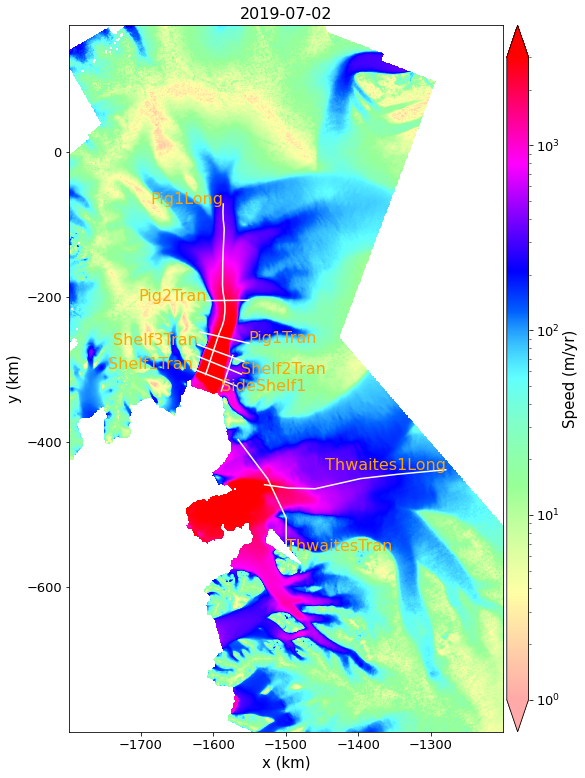

In [77]:
fig, axes = plt.subplots(1, 1, figsize=(10,13))
meanVel.displayVelForDate(ax=axes, scale='log', units='km', vmin=1, vmax=3000)
textPos = dict(zip(myProfiles, [{'ha': 'right', 'index': 0}]*len(myProfiles)))
for name in ['Pig1Tran', 'Shelf2Tran', 'SideShelf1', 'ThwaitesTran']:
    textPos[name] = {'ha': 'left', 'index': -1}
for key, tp in zip(myProfiles, textPos.values()):
    axes.plot(myProfiles[key]['x']/1000, myProfiles[key]['y']/1000,'w-')
    axes.text(myProfiles[key]['x'][tp['index']]/1000, myProfiles[key]['y'][tp['index']]/1000, key,color='orange',fontsize=16, ha=tp['ha'])

## Profile Plots

This section plots several profiles shown in the map above.

Longitudinal PIG plot.

In [78]:
result = myVelSeries.interp(np.array([-1586., -1585]), np.array([-76, -75]), returnXR=True, grid=True, units='km')
result.y

<xarray.DataArray 'y' (y: 2)>
array([-76., -75.])
Coordinates:
    name         <U4 'None'
    spatial_ref  int64 0
  * y            (y) float64 -76.0 -75.0

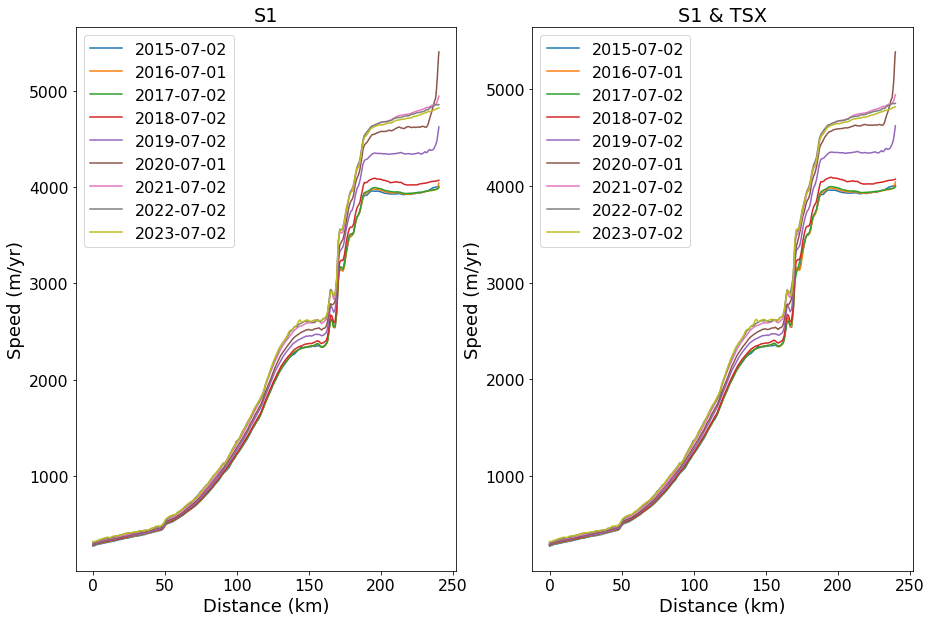

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15,10))
for date in myVelSeries.time:
    myVelSeries.plotProfile(myProfiles['Pig1Long']['x']/1000, myProfiles['Pig1Long']['y']/1000, date=date, ax=axes[0], units='km')
    myVelSeriesTSX.plotProfile(myProfiles['Pig1Long']['x']/1000, myProfiles['Pig1Long']['y']/1000, date=date, ax=axes[1], units='km')
for ax, title in zip(axes.flatten(), ['S1', 'S1 & TSX']):
    myVelSeries.labelProfilePlot(ax, fontScale=1.2, units='km', title=title)
    ax.legend(fontsize=16)
#plotProfile(myVelSeries, 'Pig1Long', axes)

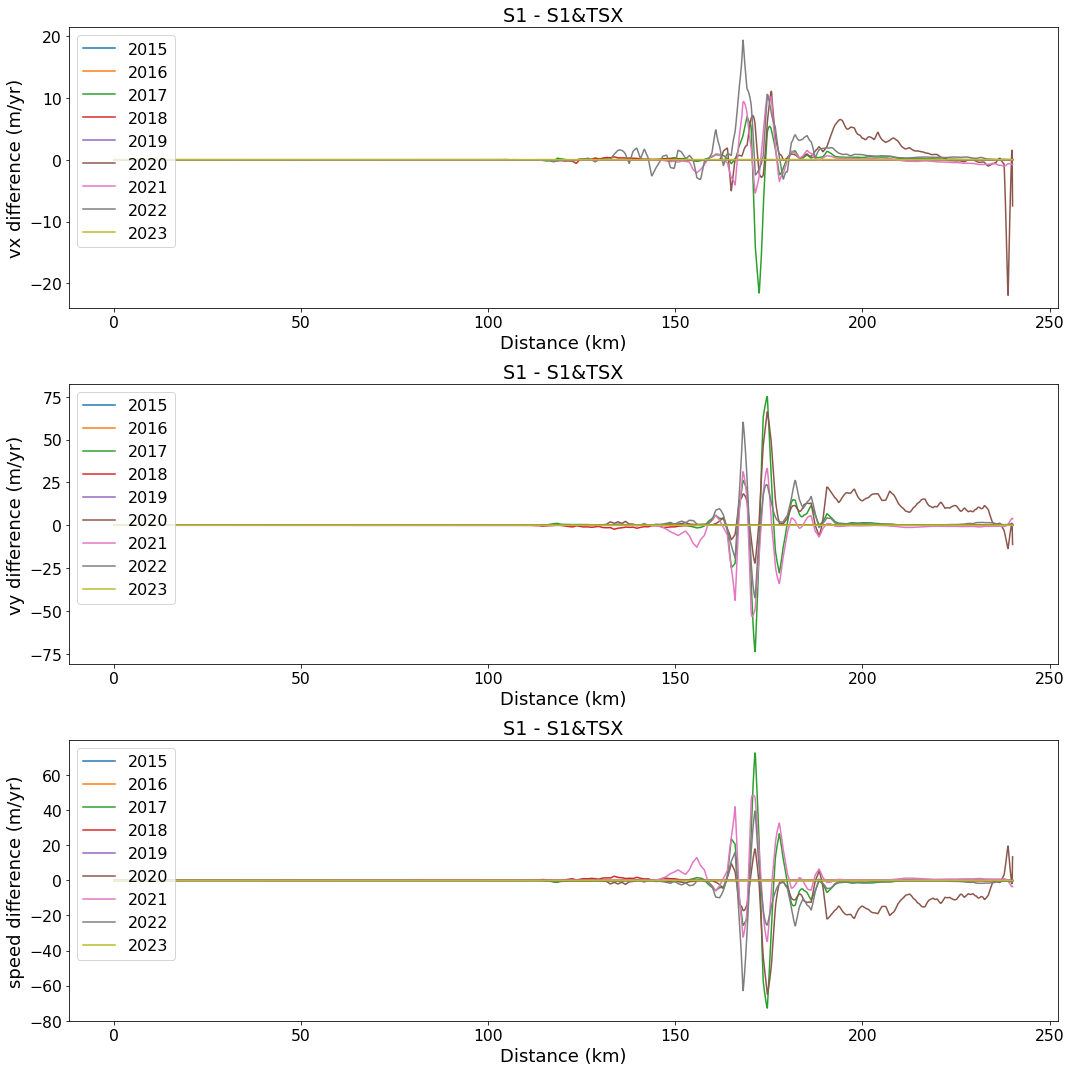

In [80]:
fig, axes = plt.subplots(3, 1, figsize=(15,15))
for date in myVelSeries.time:
    result = myVelSeries.interp(myProfiles['Pig1Long']['x']/1000, myProfiles['Pig1Long']['y']/1000, date=date, units='km')
    resultTSX = myVelSeriesTSX.interp(myProfiles['Pig1Long']['x']/1000, myProfiles['Pig1Long']['y']/1000, date=date, units='km')
    for v, vT, ax in zip(result, resultTSX, axes.flatten()):
        ax.plot(myProfiles['Pig1Long']['d']/1000, v - vT, label=date.strftime('%Y'))
    #myVelSeriesTSX.plotProfile(myProfiles['Pig1Long']['x']/1000, myProfiles['Pig1Long']['y']/1000, date=date, ax=axes[1], units='km')
                                                            
for ax, yLabel in zip(axes.flatten(), ['vx difference (m/yr)', 'vy difference (m/yr)', 'speed difference (m/yr)']):
    myVelSeries.labelProfilePlot(ax, fontScale=1.2, units='km', title='S1 - S1&TSX', yLabel=yLabel)
    ax.legend(fontsize=16, loc='upper left')
fig.tight_layout()

Time series of speed at several points along the PIG profile.

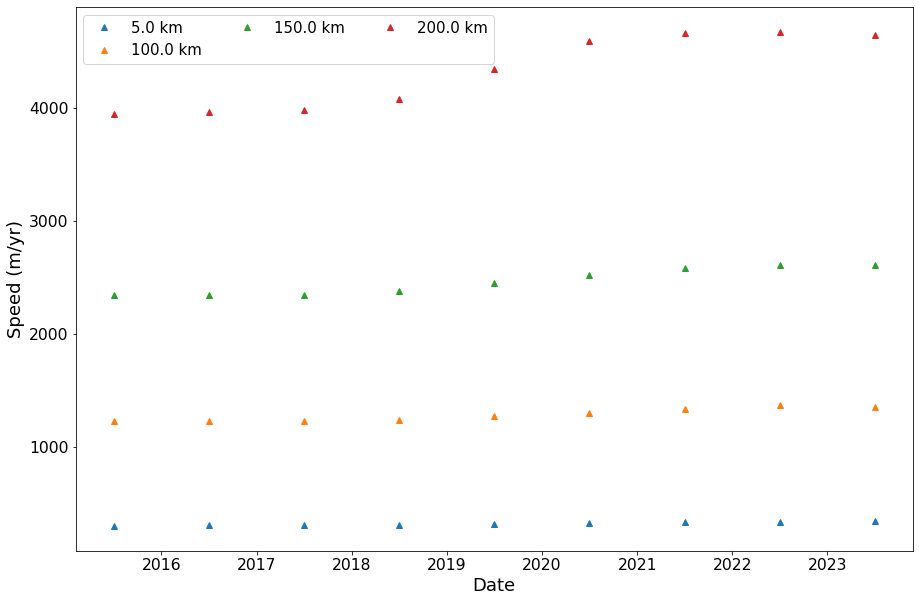

In [81]:
fig, axes = plt.subplots(1, 1, figsize=(15,10))
for i in [50, 1000, 1500, 2000]:
    # myVelSeries.plotPoint(myProfiles['Pig1Long']['x'][i]/1000, myProfiles['Pig1Long']['y'][i]/1000, '*', label=f'{i*.1} km', ax=axes, units='km')
    myVelSeriesTSX.plotPoint(myProfiles['Pig1Long']['x'][i]/1000, myProfiles['Pig1Long']['y'][i]/1000, '^', label=f'{i*.1} km', ax=axes, units='km')
myVelSeries.labelPointPlot(axes,  fontScale=1.2)
axes.legend(fontsize=15, ncol=3)

## Using lat/lon

Data can be plotted or interpolated by specifying a ```sourceEPSG```.

In [82]:
lat1, lon1 = -75.4,-96.46
vxpt, vypt, vvpt = myVelSeries.interp(lat1, lon1 ,date='2015-01-01', sourceEPSG=4326, returnXR=False, units='m')
print(vxpt, vypt, vvpt )

-64.74665144720689 -1358.7132658902428 1360.2776641874154


And with the plot.

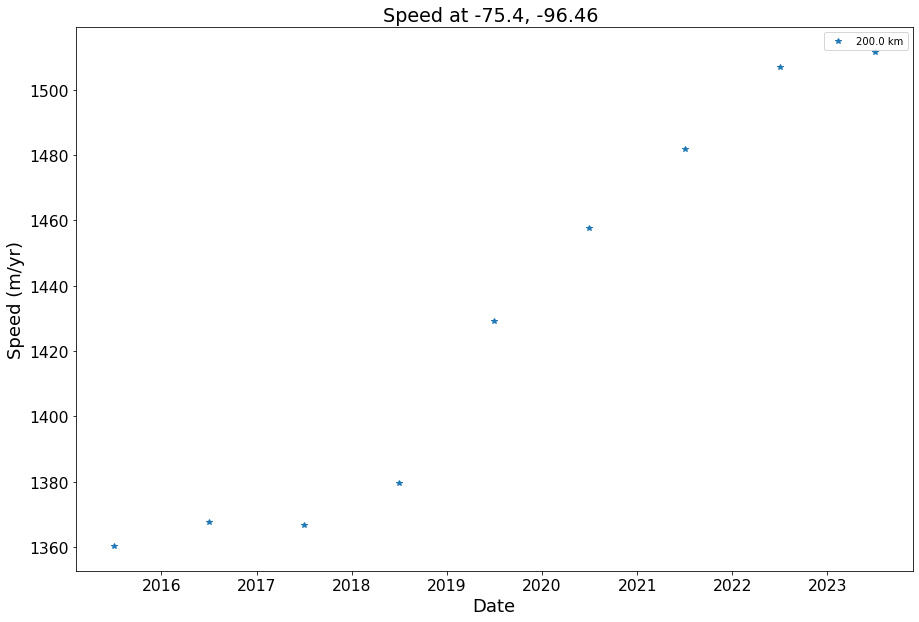

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(15,10))
myVelSeries.plotPoint(lat1, lon1,'*', label=f'{i*.1} km', ax=axes, sourceEPSG=4326)
myVelSeries.labelPointPlot(axes,  fontScale=1.2, title=f'Speed at {lat1}, {lon1} ')
axes.legend()

## Thwaites Examples

Longitudinal Thwaites plot.

Thwaites1Long
ThwaitesTran


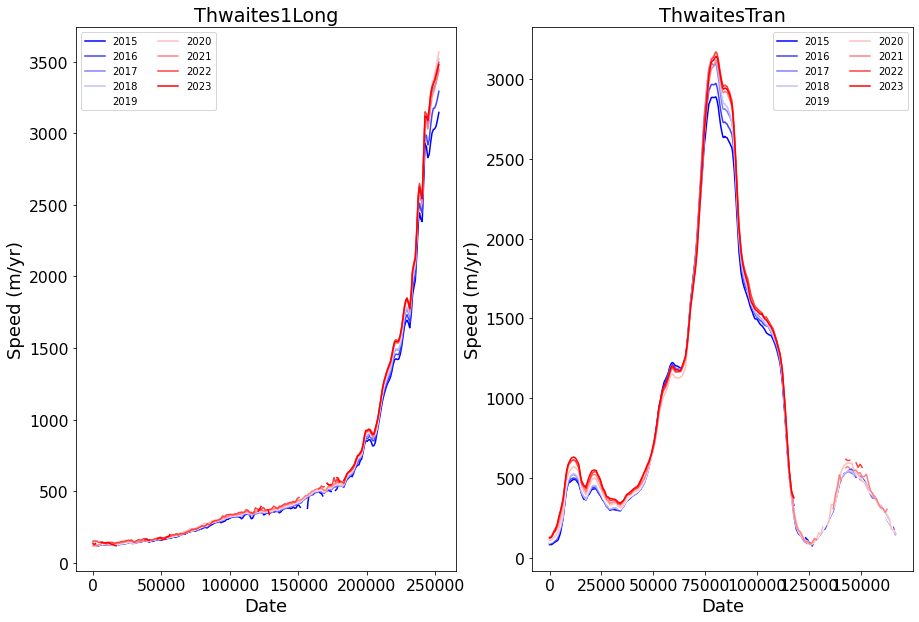

In [84]:
bwrColors = cm.get_cmap('bwr', len(myVelSeries.time))
fig, axes = plt.subplots(1, 2, figsize=(15,10))
for ax, profile in zip(axes, ['Thwaites1Long', 'ThwaitesTran']):
    print(profile)
    for date, i in zip(myVelSeries.time, range(0, len(myVelSeries.time))):
        myVelSeries.plotProfile(myProfiles[profile]['x'], myProfiles[profile]['y'], color=bwrColors(i), date=date, ax=ax, label=date.strftime('%Y'))
    myVelSeries.labelPointPlot(ax, fontScale=1.2, title=profile)
    ax.legend(ncol=2)
#plotProfile(myVelSeries, 'Thwaites1Long', axes[0])
#plotProfile(myVelSeries, 'Thwaites1Long', axes[0])

## Anomaly Plots

Compute and display the anomalies (difference from the series mean) for each map. Depending on the overviewLevel used to read the data, this may take some time.

In [70]:
anomaly = myVelSeries.anomaly()

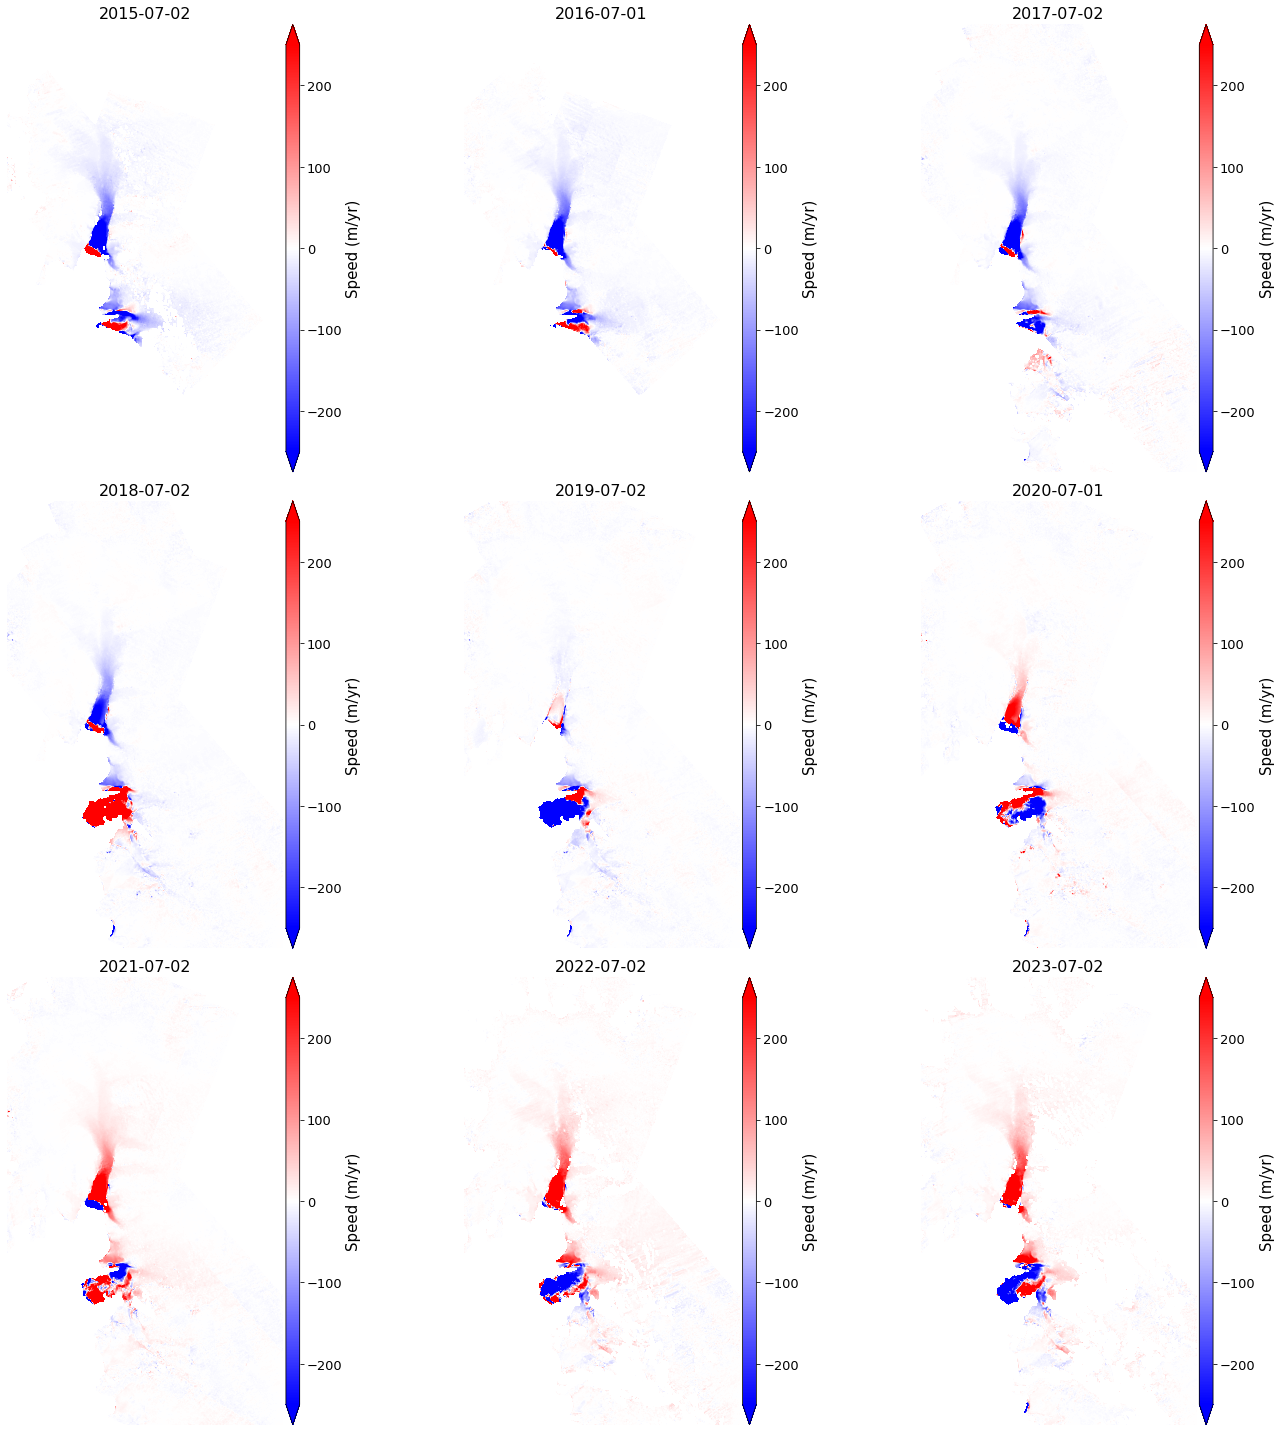

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(20,20))
for time, ax in zip(myVelSeries.time, axes.flatten()):
    anomaly.displayVelForDate(time, ax=ax, axisOff=True, vmin=-250, vmax=250, cmap='bwr', autoScale=False, extend='both')
fig.tight_layout()